In [2]:
import os
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from datetime import datetime

# Para que los gráficos se vean en el notebook
%matplotlib inline


In [6]:
# Carpeta donde tienes los ficheros de sesiones
DATA_DIR = "./data1s/SPY"

# Zona horaria de España
SPAIN_TZ = pytz.timezone("Europe/Madrid")


In [4]:
def read_session_file(file_path):
    """
    Lee un fichero Excel de IB, convierte time de UTC a España y calcula price medio
    """
    df = pd.read_excel(file_path)
    
    # Convertir columna 'time' a datetime tz-aware UTC
    df['time'] = pd.to_datetime(df['time'], utc=True)
    
    # Convertir a hora de España
    df['time_es'] = df['time'].dt.tz_convert(SPAIN_TZ)
    
    # Calcular precio medio de cada barra
    if 'high' in df.columns and 'low' in df.columns:
        df['price_avg'] = (df['high'] + df['low']) / 2
    else:
        # Si solo tienes bid/ask, usa (bid+ask)/2
        df['price_avg'] = (df['bid'] + df['ask']) / 2
    
    return df


In [17]:
files = sorted([os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.xlsx')])

# Leer un día (por ejemplo el primero)
df_day = read_session_file(files[4])

df_day.head()


,time,open,high,low,close,volume,time_es,price_avg
0,2025-09-26 13:30:00+00:00,659.51,659.54,659.37,659.37,1361.22,2025-09-26 15:30:00+02:00,659.455
1,2025-09-26 13:30:01+00:00,659.37,659.46,659.37,659.38,192.79,2025-09-26 15:30:01+02:00,659.415
2,2025-09-26 13:30:02+00:00,659.29,659.29,659.22,659.27,85.63,2025-09-26 15:30:02+02:00,659.255
3,2025-09-26 13:30:03+00:00,659.26,659.30,659.06,659.13,159.65,2025-09-26 15:30:03+02:00,659.180
4,2025-09-26 13:30:04+00:00,659.15,659.46,659.13,659.26,121.90,2025-09-26 15:30:04+02:00,659.295


In [19]:
#Añado el retorno al dataframe
# Calcular retorno: (precio actual - precio anterior) / precio actual
df_day['retorno'] = df_day['price_avg'].diff() / df_day['price_avg']


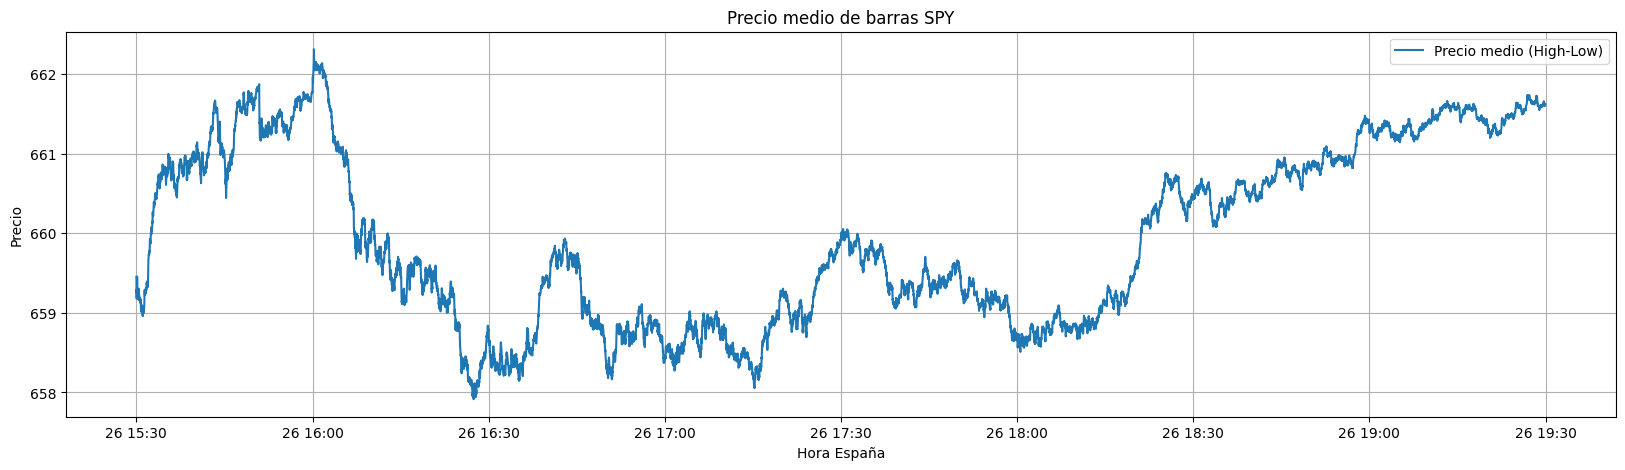

In [28]:
plt.figure(figsize=(20,5))
plt.plot(df_day['time_es'], df_day['price_avg'], label='Precio medio (High-Low)')
plt.xlabel('Hora España')
plt.ylabel('Precio')
plt.title('Precio medio de barras SPY')
plt.legend()
plt.grid(True)
plt.show()


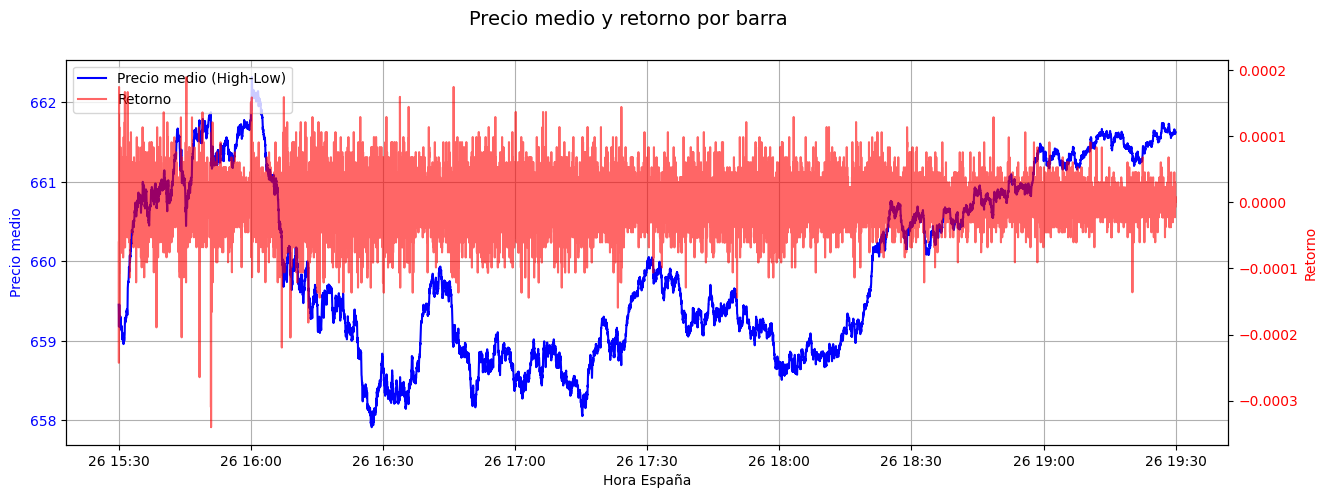

In [29]:
#gráfico con dos ejes, añadiendo el retorno.
fig, ax1 = plt.subplots(figsize=(15,5))

# Eje 1 → precio medio
ax1.plot(df_day['time_es'], df_day['price_avg'], color='blue', label='Precio medio (High-Low)')
ax1.set_xlabel('Hora España')
ax1.set_ylabel('Precio medio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear segundo eje Y
ax2 = ax1.twinx()
ax2.plot(df_day['time_es'], df_day['retorno'], color='red', alpha=0.6, label='Retorno')
ax2.set_ylabel('Retorno', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Títulos y leyenda
fig.suptitle('Precio medio y retorno por barra', fontsize=14)
ax1.grid(True)

# Leyenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


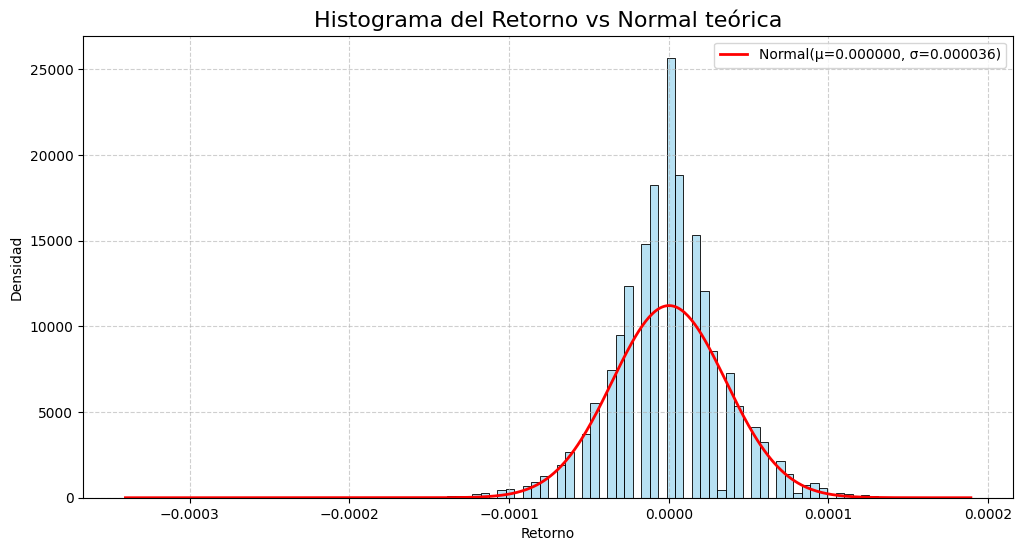

,Media,Desviación estándar,Asimetría (skew),Curtosis (kurtosis),Percentil 90
0,0.000000,0.000036,-0.204375,2.998980,0.000045


C:\BOLSA\SCRIPTS\ScriptsBolsa\TickaTick\pythonProject\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14399.
  res = hypotest_fun_out(*samples, **kwds)


📊 Test de Normalidad:
Shapiro–Wilk: estadístico=0.971649, p-valor=0.000000
Jarque–Bera: estadístico=5496.191295, p-valor=0.000000
❌ Shapiro–Wilk: se rechaza la hipótesis de normalidad (p<0.05)
❌ Jarque–Bera: se rechaza la hipótesis de normalidad (p<0.05)


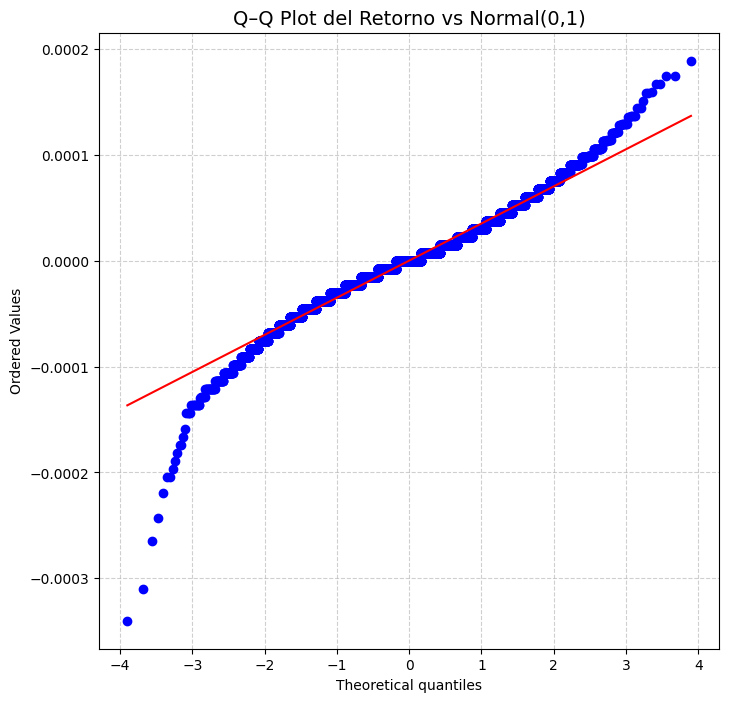

In [30]:
#Calculo histograma de los retornos
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, norm, shapiro, jarque_bera, probplot

# --- 1. Histograma + curva normal ajustada ---
plt.figure(figsize=(12,6))

ret = df_day['retorno'].dropna()

# Histograma normalizado
sns.histplot(
    ret, 
    bins=100, 
    kde=False, 
    stat="density", 
    color='skyblue', 
    edgecolor='black',
    alpha=0.6
)

# Calcular media y sigma
mu, sigma = ret.mean(), ret.std()

# Rango en x para PDF
x = np.linspace(ret.min(), ret.max(), 500)
pdf = norm.pdf(x, mu, sigma)

# Dibujar curva normal teórica
plt.plot(x, pdf, 'r-', lw=2, label=f'Normal(μ={mu:.6f}, σ={sigma:.6f})')

plt.title('Histograma del Retorno vs Normal teórica', fontsize=16)
plt.xlabel('Retorno')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 2. Tabla numérica con estadísticos ---
tabla = pd.DataFrame({
    "Media": [mu],
    "Desviación estándar": [sigma],
    "Asimetría (skew)": [skew(ret)],
    "Curtosis (kurtosis)": [kurtosis(ret)],
    "Percentil 90": [ret.quantile(0.90)]
})

import IPython.display as disp
disp.display(tabla.style.format("{:.6f}"))

# --- 3. Tests de normalidad ---
shap_stat, shap_p = shapiro(ret)
jb_stat, jb_p = jarque_bera(ret)

print("📊 Test de Normalidad:")
print(f"Shapiro–Wilk: estadístico={shap_stat:.6f}, p-valor={shap_p:.6f}")
print(f"Jarque–Bera: estadístico={jb_stat:.6f}, p-valor={jb_p:.6f}")

if shap_p < 0.05:
    print("❌ Shapiro–Wilk: se rechaza la hipótesis de normalidad (p<0.05)")
else:
    print("✅ Shapiro–Wilk: no se rechaza la normalidad (p>=0.05)")

if jb_p < 0.05:
    print("❌ Jarque–Bera: se rechaza la hipótesis de normalidad (p<0.05)")
else:
    print("✅ Jarque–Bera: no se rechaza la normalidad (p>=0.05)")

# --- 4. Q-Q Plot ---
plt.figure(figsize=(8,8))
probplot(ret, dist="norm", plot=plt)
plt.title("Q–Q Plot del Retorno vs Normal(0,1)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



Resumen de estadísticas:
    Estadística         Valor
0         Media  2.275211e-07
1       Mediana  0.000000e+00
2  Percentil 90  4.538763e-05
3          Skew           NaN
4      Kurtosis           NaN


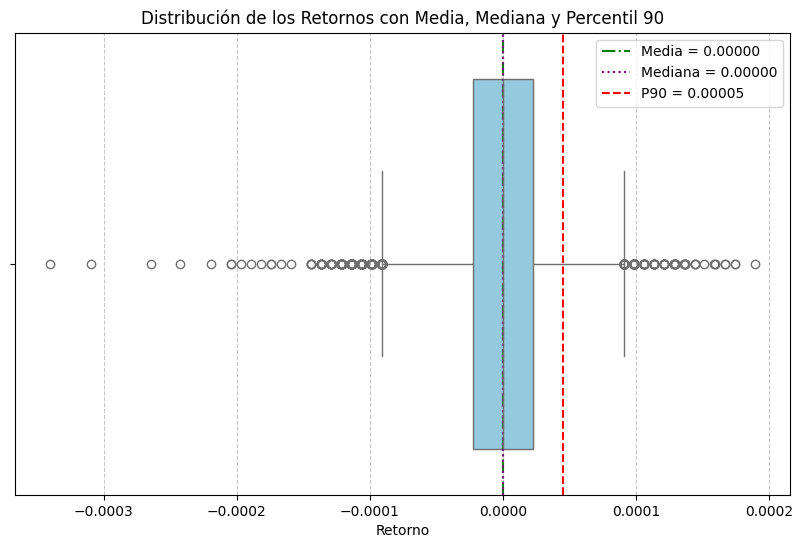

In [34]:
#Pinto BoxPlot con perceptil 90 marcado
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Calcular estadísticas
mean_ret = df_day['retorno'].mean()
median_ret = df_day['retorno'].median()
p90 = df_day['retorno'].quantile(0.9)
skew_ret = skew(df_day['retorno'])
kurt_ret = kurtosis(df_day['retorno'])

# Crear tabla resumen
summary_table = pd.DataFrame({
    "Estadística": ["Media", "Mediana", "Percentil 90", "Skew", "Kurtosis"],
    "Valor": [mean_ret, median_ret, p90, skew_ret, kurt_ret]
})

# Mostrar tabla
print("Resumen de estadísticas:")
print(summary_table)

# Gráfico
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_day['retorno'], orient="h", color="skyblue")

# Añadir líneas de referencia
plt.axvline(mean_ret, color="green", linestyle="-.", label=f"Media = {mean_ret:.5f}")
plt.axvline(median_ret, color="purple", linestyle=":", label=f"Mediana = {median_ret:.5f}")
plt.axvline(p90, color="red", linestyle="--", label=f"P90 = {p90:.5f}")

plt.title("Distribución de los Retornos con Media, Mediana y Percentil 90")
plt.xlabel("Retorno")
plt.legend()
plt.grid(True, axis='x', linestyle="--", alpha=0.7)
plt.show()
